In [1]:
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load credit card transation data
path = 'C:/Projects/NLP/Data/'
credit_card = pd.read_csv(f'{path}creditcard.csv')

In [3]:
credit_card.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Plot the balance of class labels
credit_card_base = credit_card.copy()

0 = nominal transactions, 1 = fraud


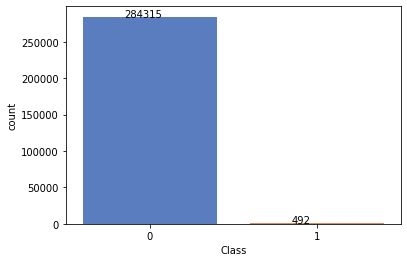

In [5]:
print('0 = nominal transactions, 1 = fraud')
value_counts = credit_card_base['Class'].value_counts()
ax = sns.countplot(x="Class", data=credit_card_base, palette='muted')
for p in ax.patches:
       ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

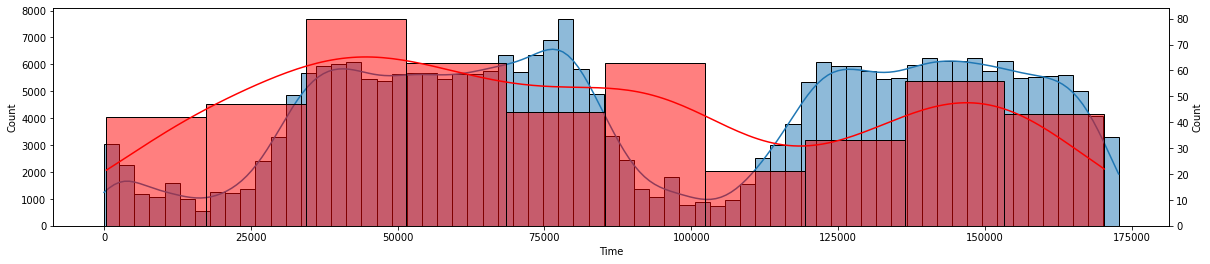

In [6]:
# Plot istribution of the Time variable, which contains transaction data for two days
plt.figure(figsize=(20,4))
ax1 = sns.histplot(data=credit_card_base[credit_card_base['Class'] == 0], x='Time', kde=True)
ax2 = plt.twinx()
ax2 = sns.histplot(data=credit_card_base[credit_card_base['Class'] == 1], x='Time', kde=True, ax=ax2, color='r')

plt.show()


Text(0.5, 0.98, 'Transaction Amount over Time split by Class')

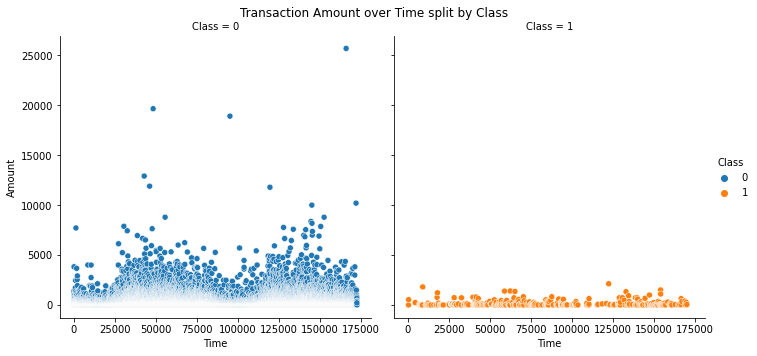

In [7]:
# Plot time against amount
x = credit_card_base['Time']
y = credit_card_base['Amount']
rp = sns.relplot(data=credit_card_base, x=x, y=y, col="Class", kind="scatter", hue="Class")
rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Transaction Amount over Time split by Class')

In [8]:
# Separate the classes from the train set
df_classes = credit_card_base['Class']
df_train = credit_card_base.drop(['Class'], axis=1)

# split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(df_train, df_classes, test_size=0.30, random_state=42)

### Isolation Forest

In [9]:
# Define the parameter grid
n_estimators=[50, 100]
max_features=[1.0, 5, 10]
bootstrap=[True]

param_grid = dict(n_estimators=n_estimators, max_features=max_features, bootstrap=bootstrap)

In [10]:
param_grid

{'n_estimators': [50, 100], 'max_features': [1.0, 5, 10], 'bootstrap': [True]}

In [11]:
value_counts = credit_card_base['Class'].value_counts()
contamination_rate = value_counts[1]/value_counts[0]

In [12]:
contamination_rate

0.0017304750013189597

In [13]:
# Build the gridsearch
model_isf = IsolationForest(n_estimators=n_estimators, 
                            max_features=max_features, 
                            contamination=contamination_rate, 
                            bootstrap=False, 
                            n_jobs=-1)

In [14]:
# Define an f1_scorer
f1sc = make_scorer(f1_score, average='macro')

In [15]:
grid = GridSearchCV(estimator=model_isf, param_grid=param_grid, cv = 3, scoring=f1sc)

grid_results = grid.fit(X=X_train, y=y_train)

In [16]:
# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

Best: [0.00089946 0.00090953 0.000846   0.00090273 0.00088277 0.00091956], using {'bootstrap': True, 'max_features': 10, 'n_estimators': 100}


In [17]:
results_df = pd.DataFrame(grid_results.cv_results_)

results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,7.317015,5.061244,1.476974,0.034365,True,1.0,50,"{'bootstrap': True, 'max_features': 1.0, 'n_es...",0.000893,0.000933,0.000873,0.000899,0.000025,4
1,6.967961,0.063783,2.910349,0.018661,True,1.0,100,"{'bootstrap': True, 'max_features': 1.0, 'n_es...",0.000853,0.000953,0.000923,0.000910,0.000042,2
2,2.638333,0.070275,1.019865,0.002418,True,5,50,"{'bootstrap': True, 'max_features': 5, 'n_esti...",0.000813,0.000843,0.000883,0.000846,0.000029,6
3,4.864497,0.073191,2.020131,0.043469,True,5,100,"{'bootstrap': True, 'max_features': 5, 'n_esti...",0.000823,0.000903,0.000983,0.000903,0.000065,3
4,2.958886,0.114521,1.154352,0.010400,True,10,50,"{'bootstrap': True, 'max_features': 10, 'n_est...",0.000833,0.000963,0.000853,0.000883,0.000057,5
5,5.315652,0.037648,2.273563,0.034348,True,10,100,"{'bootstrap': True, 'max_features': 10, 'n_est...",0.000863,0.000923,0.000973,0.000920,0.000045,1


In [18]:
# Evaluate model performance
model_name = 'Isolation Forest (tuned)'
# get the bet model parameters
best_model = grid_results.best_estimator_
best_model

IsolationForest(bootstrap=True, contamination=0.0017304750013189597,
                max_features=10, n_jobs=-1)

In [19]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset
    df_pred_test = X_test.copy()
    df_pred_test['Pred'] = model.predict(X_test)

    if map_labels:
        df_pred_test['Pred'] = df_pred_test['Pred'].map({1: 0, -1: 1})

    # measure performance
    y_pred = df_pred_test['Pred'] 
    matrix = confusion_matrix(y_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                                     xticklabels=['Regular [0]', 'Fraud [1]'], 
                                     yticklabels=['Regular [0]', 'Fraud [1]'], 
                                     annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(y_pred, y_true))
    
    model_score = score(y_pred, y_true, average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')

    return model_score

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85294
           1       0.36      0.33      0.34       149

    accuracy                           1.00     85443
   macro avg       0.68      0.66      0.67     85443
weighted avg       1.00      1.00      1.00     85443

f1_score: 67.14%


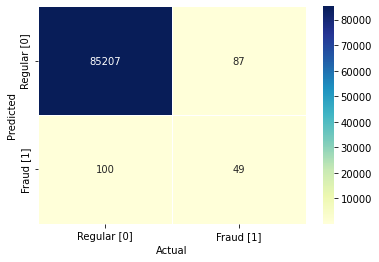

In [20]:
map_labels = True # if True - maps 1 to 0 and -1 to 1 - not required for scikit-learn knn models
model_score = measure_performance(best_model, X_test, y_test, map_labels)

In [21]:
model_score

(0.6795609404510629, 0.663919529497893, 0.671381762123317, None)

In [22]:
performance_df = pd.DataFrame().append({'model_name':model_name, 
                                        'f1_score': model_score[0], 
                                        'precision': model_score[1], 
                                        'recall': model_score[2]}, ignore_index=True)

### KNN

In [23]:
# Define hypertuning parameters
n_neighbors=[1, 2, 3, 4, 5]
param_grid = dict(n_neighbors=n_neighbors)

In [24]:
# Build the gridsearch
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
grid = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv = 5, scoring=f1sc)
grid_results = grid.fit(X=X_train, y=y_train)

In [25]:
# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

results_df

Best: [0.61083219 0.55718259 0.55912644 0.52670328 0.5317127 ], using {'n_neighbors': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041118,0.008080,81.319043,0.531133,1,{'n_neighbors': 1},0.629535,0.611768,0.583553,0.585538,0.643766,0.610832,0.023746,1
1,0.047889,0.004651,92.046819,1.002642,2,{'n_neighbors': 2},0.589342,0.540114,0.565375,0.539567,0.551515,0.557183,0.018629,3
2,0.047619,0.003681,99.287034,0.571852,3,{'n_neighbors': 3},0.589342,0.552205,0.563676,0.539567,0.550843,0.559126,0.016928,2
3,0.045292,0.002809,146.999125,7.520004,4,{'n_neighbors': 4},0.526964,0.526964,0.540114,0.513253,0.526221,0.526703,0.008498,5
4,0.047248,0.000746,146.828243,7.930471,5,{'n_neighbors': 5},0.539567,0.540114,0.540114,0.513253,0.525516,0.531713,0.010789,4


In [26]:
# Evaluate model performance
model_name = 'KNN'

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85385
           1       0.21      0.48      0.29        58

    accuracy                           1.00     85443
   macro avg       0.60      0.74      0.64     85443
weighted avg       1.00      1.00      1.00     85443

f1_score: 64.39%


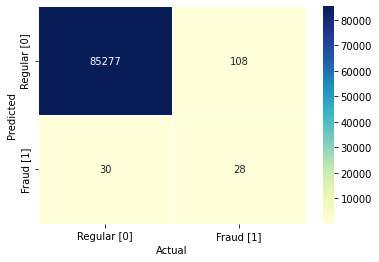

In [27]:
best_model = grid_results.best_estimator_
map_labels = False # if True - maps 1 to 0 and -1 to 1 - set to False for classification models (e.g., KNN)
model_score = measure_performance(best_model, X_test, y_test, map_labels)

In [28]:
performance_df = performance_df.append({'model_name':model_name, 
                                        'f1_score': model_score[0], 
                                        'precision': model_score[1], 
                                        'recall': model_score[2]}, ignore_index=True)

### Local Outlier Factor

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.07      0.07      0.07       144

    accuracy                           1.00     85443
   macro avg       0.54      0.53      0.53     85443
weighted avg       1.00      1.00      1.00     85443

f1_score: 53.5%


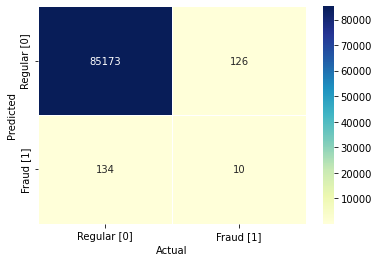

In [29]:
# Train a tuned local outlier factor model
model_lof = LocalOutlierFactor(n_neighbors=3, contamination=contamination_rate, novelty=True)
model_lof.fit(X_train)

# Evaluate model performance
model_name = 'Local Outlier Factor'

map_labels = True 
model_score = measure_performance(model_lof, X_test, y_test, map_labels)

In [30]:
performance_df = performance_df.append({'model_name':model_name, 
                                        'f1_score': model_score[0], 
                                        'precision': model_score[1], 
                                        'recall': model_score[2]}, ignore_index=True)

### Comparing Model Performance

In [31]:
performance_df

,model_name,f1_score,precision,recall
0,Isolation Forest (tuned),0.679561,0.663920,0.671382
1,KNN,0.602765,0.740747,0.643926
2,Local Outlier Factor,0.535979,0.533984,0.534952


Text(0.5, 1.0, 'Model Outlier Detection Performance (Macro)')

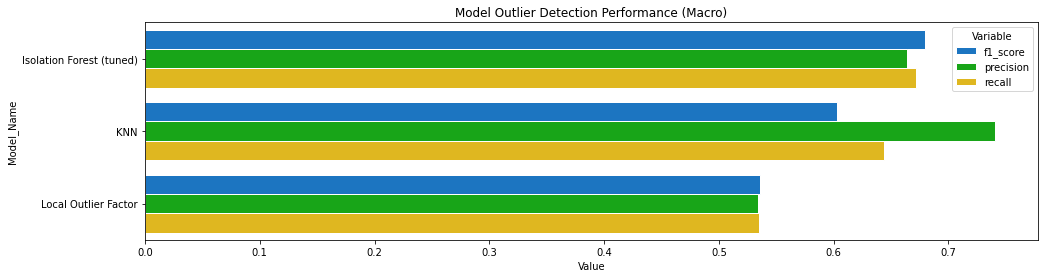

In [32]:
performance_df = performance_df.sort_values('model_name')

fig, ax = plt.subplots(figsize=(16, 4))
tidy = performance_df.melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tidy, ax=ax, palette='nipy_spectral', linewidth=1, edgecolor="w")
plt.title('Model Outlier Detection Performance (Macro)')